In [3]:
# for file paths
import os

# importing other dependencies
import numpy as np
import pandas as pd

# import tensorflow
import torch
import torchvision

# import for pre-trained segmentation models
import segmentation_models_pytorch as smp
# for pre-processing
from segmentation_models_pytorch.encoders import get_preprocessing_fn

# plotting
import matplotlib.pyplot as plt

# import opencv
import cv2

In [4]:
# checks whether MPS is available
print(torch.backends.mps.is_available())

# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

# setting the device to "mps" instead of default "cpu"
device = torch.device("mps" if torch.backends.mps.is_available else "cpu")

True
True


In [5]:
# we define a helper function to print the image using `matplotlib`

# this prints colored image
def print_image(img, isGray=False, title="Image"):
    # OpenCV reads images in BGR, and matplotlib reads images in RGB
    # so, we switch the color channels using `cvtColor` method
    
    # if isGray = True, we first grayscale the image using the same `cvtColor` method
    if isGray:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_colored = cv2.cvtColor(img_gray, cv2.COLOR_BGR2RGB)
    else:
        img_colored = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10,6))
    plt.imshow(img_colored)
    plt.axis(False)
    plt.title(title)
    plt.show()


In [6]:
# define helper fucntion to extract pathname of images in a folder

def extract_path(dir_path):
    # Create a list to store the file paths
    file_paths = []

    # Loop through all files in the directory
    for filename in os.listdir(dir_path):
        # Check if the file is an image file (e.g. .jpg, .jpeg, .png, .jfif etc.)
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png") or filename.endswith(".jfif"):
            # Add the full file path to the list
            file_paths.append(os.path.join(dir_path, filename))
    
    return file_paths

In [7]:
# laser cut images path
laser_cut_folder_path = os.path.join('data', 'cad_data', 'laser_parts')
img_paths = extract_path(laser_cut_folder_path)
len(img_paths)

22

In [8]:
def run_pipeline(img_path_list, pipeline, n_imgs=10, random_seed=69):
    # set random seed
    np.random.seed(random_seed)
    
    rand_idx = np.random.choice(len(img_paths), n_imgs, replace=False)

    # for each idx
    for i in range(n_imgs):
        idx = rand_idx[i]
        img_path = img_path_list[idx]
        # read the image
        img = cv2.imread(img_path)

        plt.figure(figsize=(6,8))
        
        # view the original image
        plt.subplot(1, 2, 1)
        img_colored = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_colored)
        plt.grid(False)
        plt.axis(False)
        
        # view the transformed image
        plt.subplot(1, 2, 2)
        img_transformed = pipeline(img_path)
        img_transformed_colored = cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB)
        plt.imshow(img_transformed_colored)
        plt.grid(False)
        plt.axis(False)

        plt.show()


# Image processing pipelines

In [40]:
# histogram equalization

def histeq(img_path):
    # Load the image of the sheet metal part
    img = cv2.imread(img_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Perform histogram equalization on the grayscale image
    eq_hist_img = cv2.equalizeHist(gray)

    return eq_hist_img


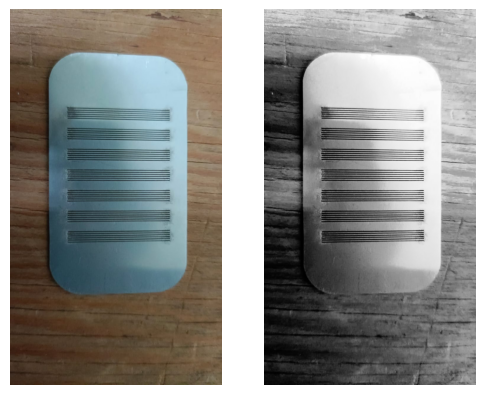

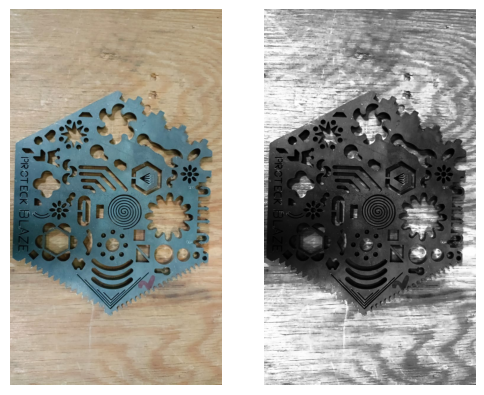

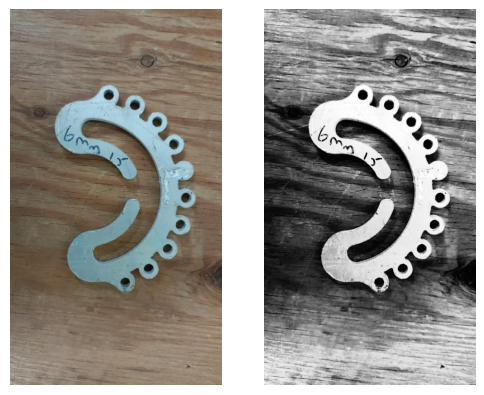

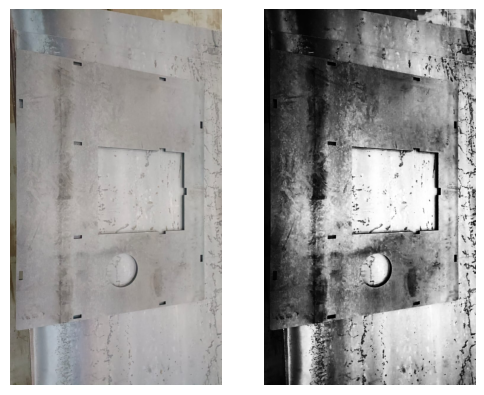

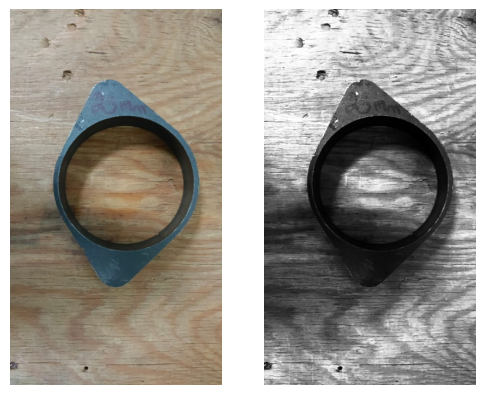

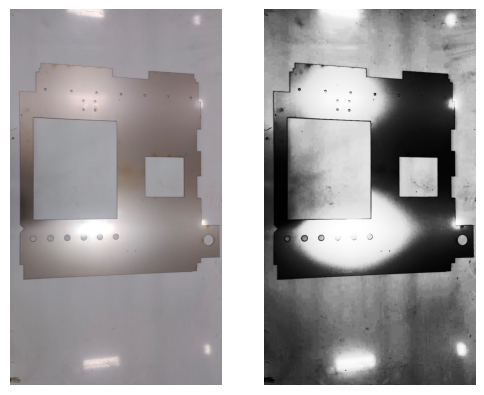

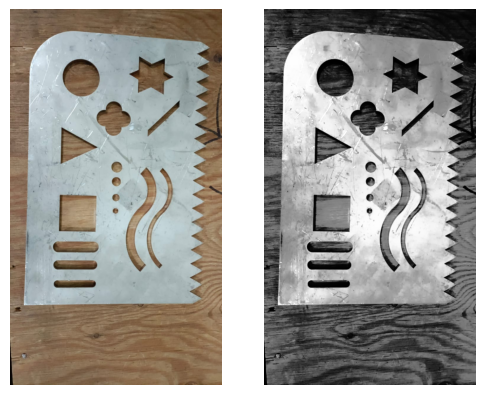

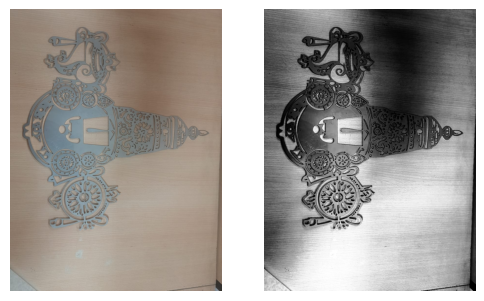

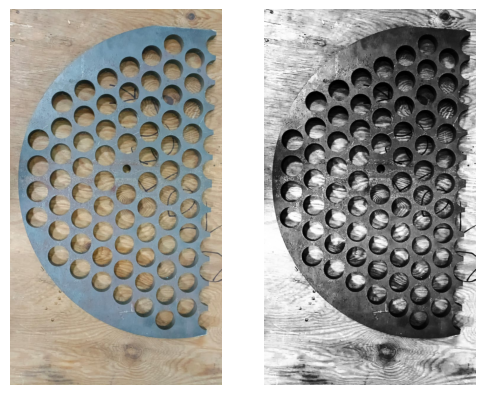

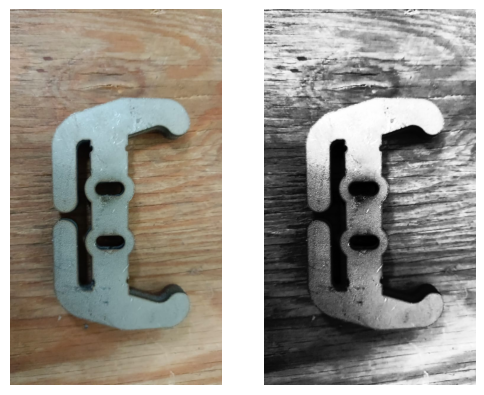

In [41]:
run_pipeline(img_paths, histeq, random_seed=12)

In [42]:
# pipeline-1

def img2cut_1(img_path):
    # Load the image of the sheet metal part
    img = cv2.imread(img_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Otsu's thresholding to segment the metal part
    thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Calculate the bounding rectangle of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # We add some border tolerance
    btol = 10
    w += btol
    h += btol
    
    # Crop the image to just the bounding rectangle
    cropped = img[y:y+h, x:x+w]

    # Convert the cropped image to grayscale
    cropped_gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    cropped_blurred = cv2.GaussianBlur(cropped_gray, (5, 5), 0)

    # Apply Canny edge detection
    cropped_edges = cv2.Canny(cropped_blurred, 50, 150)

    # Find contours in the cropped edge map
    cropped_contours, _ = cv2.findContours(cropped_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw the contours on a black image
    dxf_img = np.zeros((cropped.shape[0], cropped.shape[1], 3), dtype=np.uint8)
    cv2.drawContours(dxf_img, cropped_contours, -1, (255, 255, 255), 2)
    
    return dxf_img

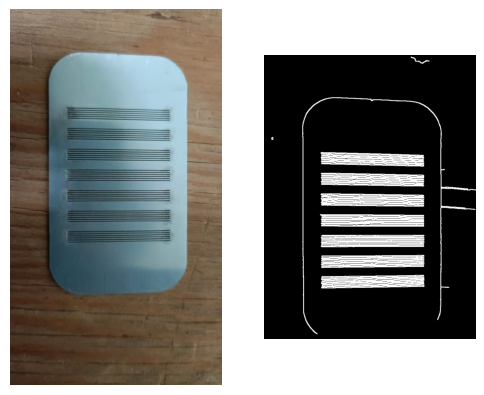

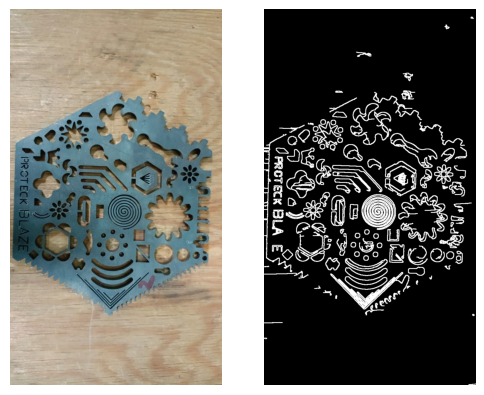

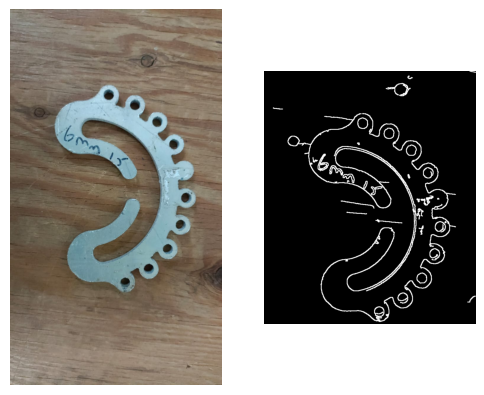

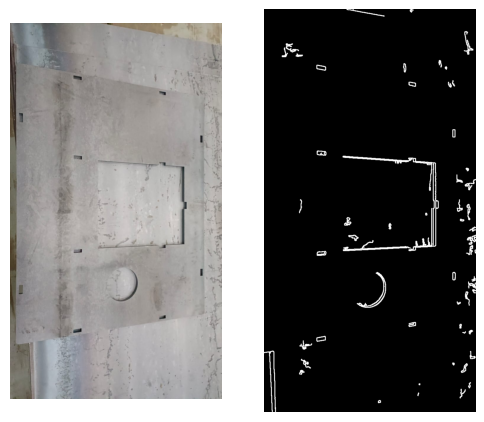

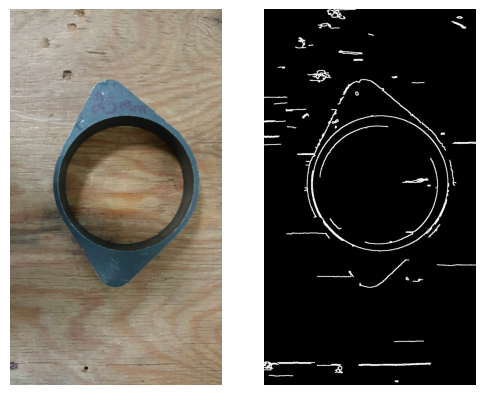

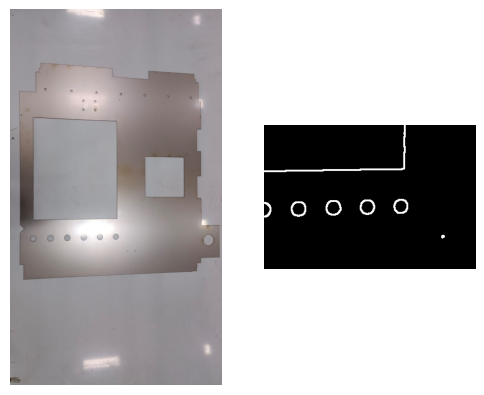

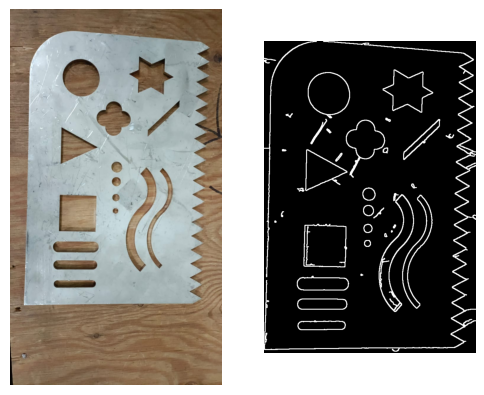

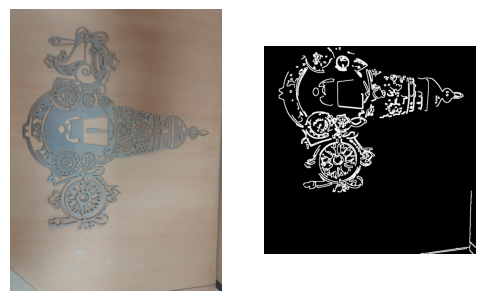

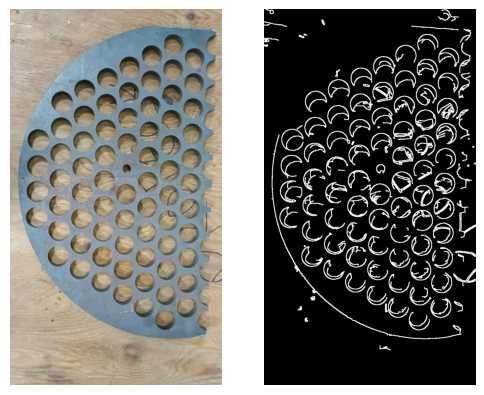

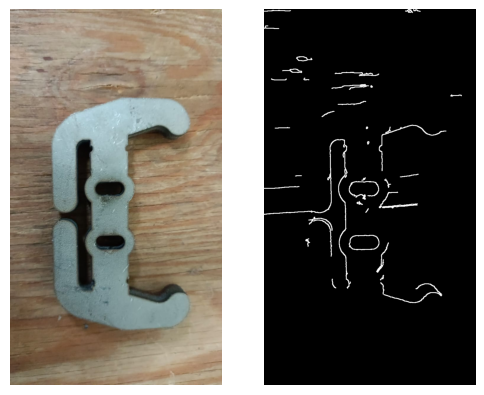

In [43]:
run_pipeline(img_paths, img2cut_1, random_seed=12)

In [44]:
# pipeline-2

def img2cut_2(img_path):
    # Load the image of the sheet metal part
    img = cv2.imread(img_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Otsu's thresholding to segment the metal part
    thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Calculate the bounding rectangle of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the image to just the bounding rectangle
    cropped = img[y:y+h, x:x+w]

    # Convert the cropped image to grayscale
    cropped_gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    cropped_blurred = cv2.GaussianBlur(cropped_gray, (5, 5), 0)

    # Apply Canny edge detection
    cropped_edges = cv2.Canny(cropped_blurred, 50, 150)

    # Apply morphological dilation to increase the size of the edges
    kernel = np.ones((3, 3), np.uint8)
    cropped_dilation = cv2.dilate(cropped_edges, kernel, iterations=1)

    # Apply morphological erosion to reduce the size of the edges
    cropped_erosion = cv2.erode(cropped_dilation, kernel, iterations=1)

    # Find contours in the cropped edge map
    cropped_contours, _ = cv2.findContours(cropped_erosion, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw the contours on a black image
    dxf_img = np.zeros((cropped.shape[0], cropped.shape[1], 3), dtype=np.uint8)
    cv2.drawContours(dxf_img, cropped_contours, -1, (255, 255, 255), 2)
    
    return dxf_img

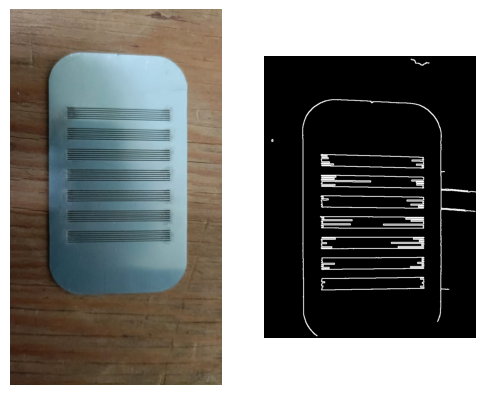

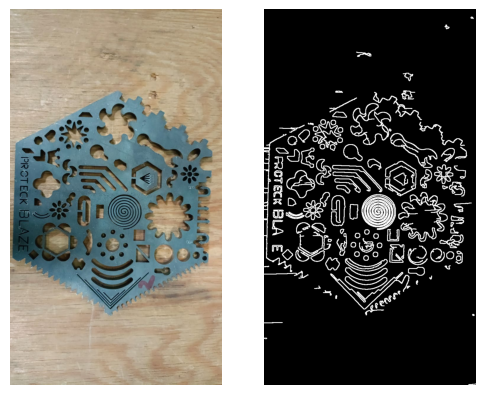

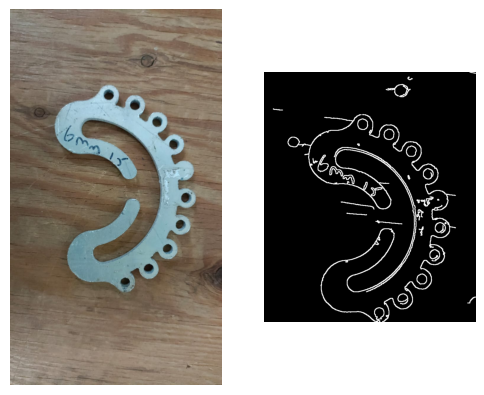

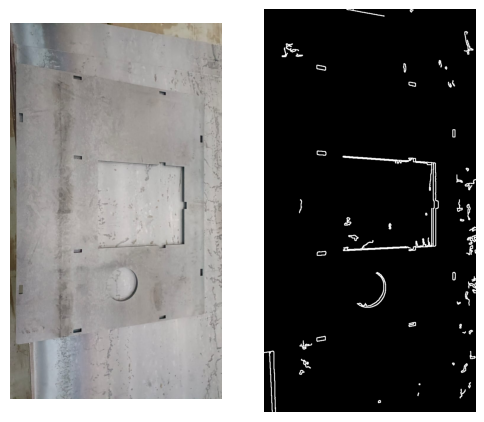

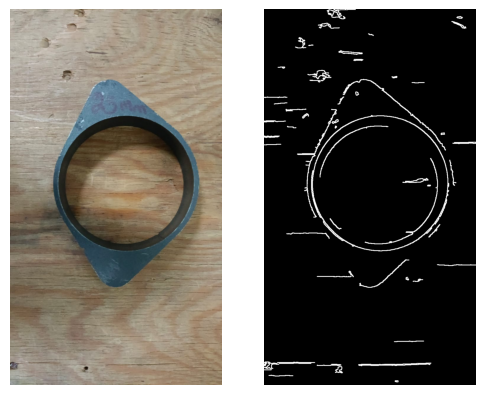

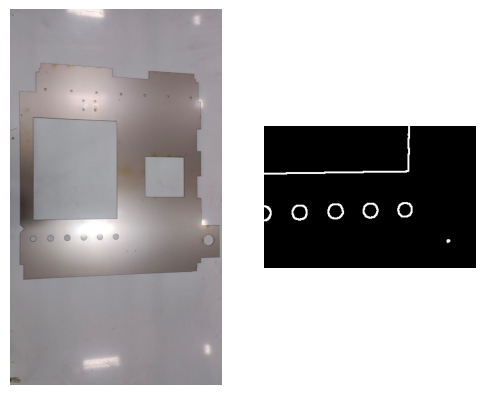

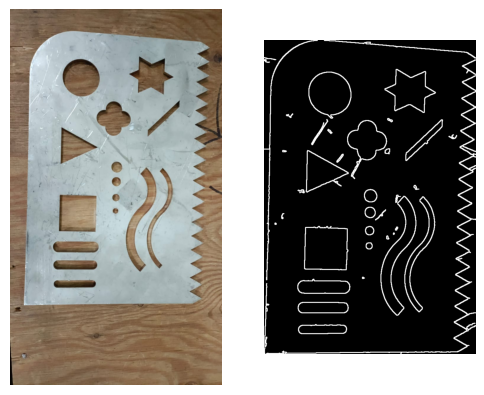

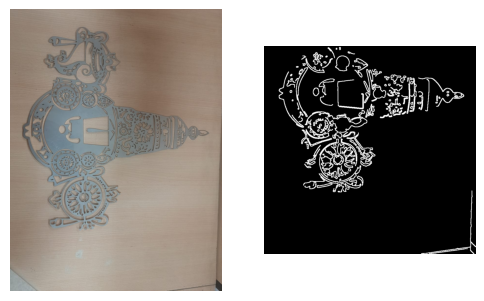

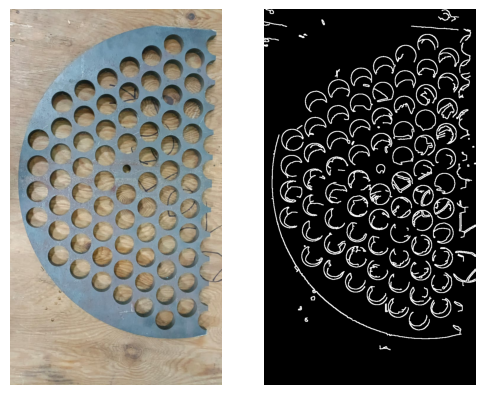

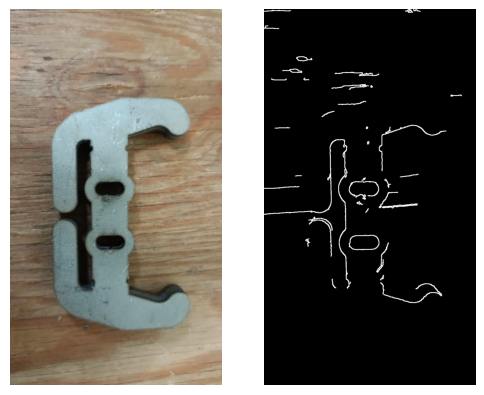

In [45]:
run_pipeline(img_paths, img2cut_2, random_seed=12)

In [46]:
def img2cut_3(img_path):
    # Load the image of the sheet metal part
    img = cv2.imread(img_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Otsu's thresholding to segment the metal part
    thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Calculate the bounding rectangle of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the image to just the bounding rectangle
    cropped = img[y:y+h, x:x+w]

    # Convert the cropped image to grayscale
    cropped_gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    cropped_blurred = cv2.GaussianBlur(cropped_gray, (5, 5), 0)

    # Apply Canny edge detection with higher thresholds
    cropped_edges = cv2.Canny(cropped_blurred, 100, 200)

    # Apply morphological dilation to increase the size of the edges
    kernel = np.ones((3, 3), np.uint8)
    cropped_dilation = cv2.dilate(cropped_edges, kernel, iterations=1)

    # Apply morphological erosion to reduce the size of the edges
    cropped_erosion = cv2.erode(cropped_dilation, kernel, iterations=1)

    # Find contours in the cropped edge map
    cropped_contours, _ = cv2.findContours(cropped_erosion, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw the contours on a black image
    dxf_img = np.zeros((cropped.shape[0], cropped.shape[1], 3), dtype=np.uint8)
    cv2.drawContours(dxf_img, cropped_contours, -1, (255, 255, 255), 2)
    
    return dxf_img


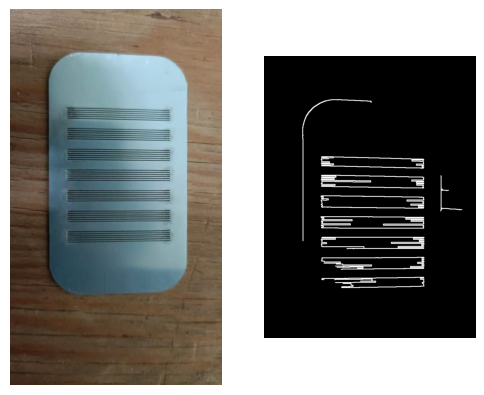

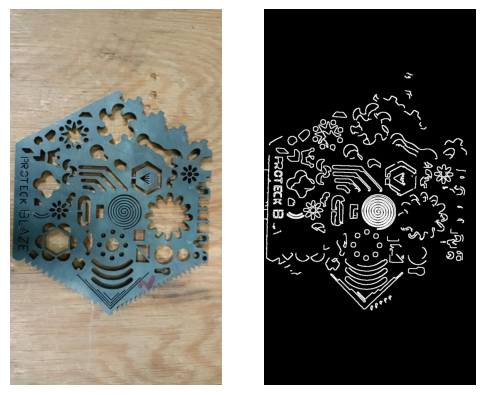

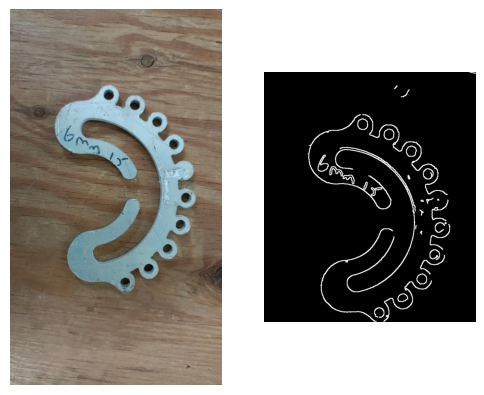

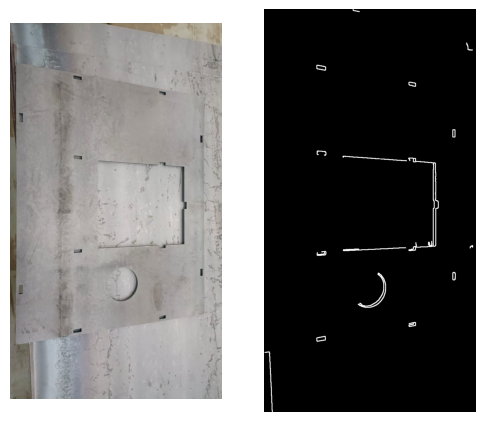

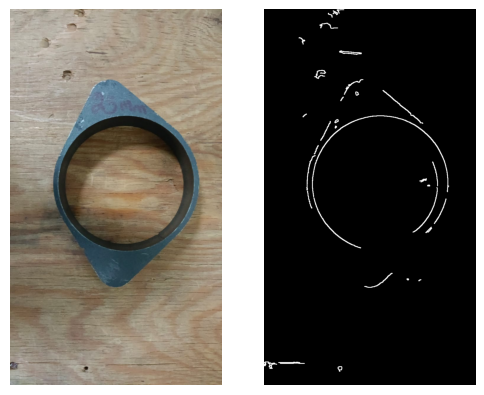

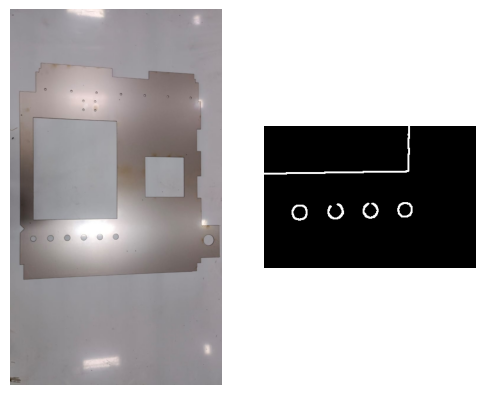

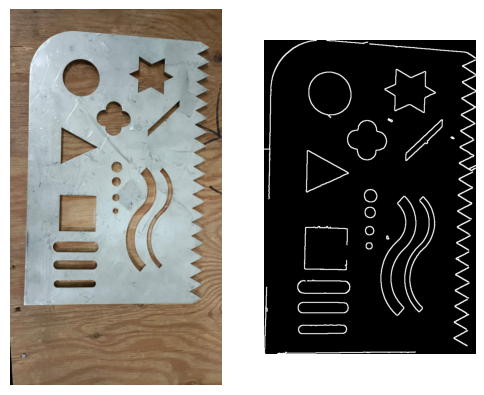

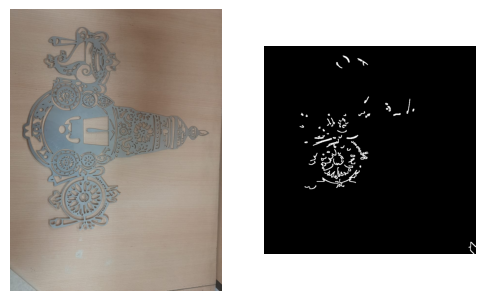

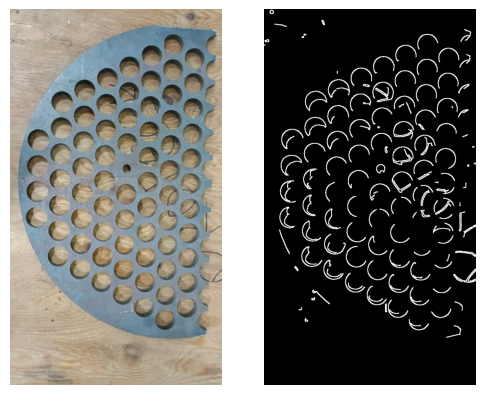

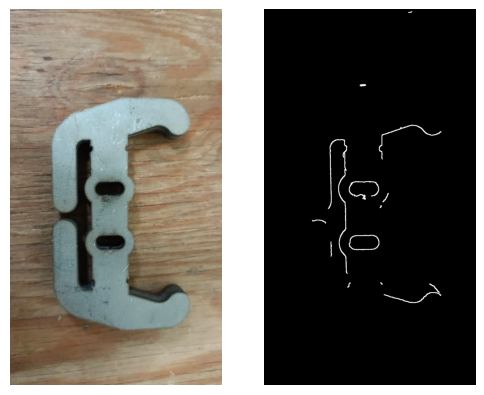

In [47]:
run_pipeline(img_paths, img2cut_3, random_seed=12)

In [78]:
def process_sheet_metal(img_path):
    # Load the image of the sheet metal part
    img = cv2.imread(img_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Adaptive Thresholding to segment the metal part
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # Apply morphological closing to fill small gaps
    kernel = np.ones((3, 3), np.uint8)
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Apply Canny edge detection
    edges = cv2.Canny(closed, 50, 150)

    # Apply morphological dilation to increase the size of the edges
    dilation = cv2.dilate(edges, kernel, iterations=1)

    # Find contours in the edge map
    contours, _ = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw the contours on a black image
    dxf_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    cv2.drawContours(dxf_img, contours, -1, (255, 255, 255), 2)

    return dxf_img


In [ ]:
run_pipeline(img_paths, process_sheet_metal, random_seed=12)

In [13]:
img_path = img_paths[1]
# Load the image and pre-process it
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224)) / 255.0
img = np.transpose(img, (2, 0, 1))
img = torch.from_numpy(img).float()

# Use a semantic segmentation model to predict the pixels belonging to the sheet metal part
# download pre-trained DeepLabV3 model
from torchvision.models.segmentation import deeplabv3_resnet101
model = deeplabv3_resnet101()
model.eval()
with torch.no_grad():
    preds = model(img.unsqueeze(0))

# Extract the contour of the sheet metal part
preds = preds.squeeze().numpy()
mask = np.zeros_like(preds)
mask[preds >= 0.5] = 1
contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Select the outermost contour
contour = max(contours, key=cv2.contourArea)

# Create a mask of the same size as the image
mask = np.zeros_like(img)
cv2.drawContours(mask, [contour], -1, (255, 255, 255), -1)

# Multiply the mask with the original image to retain only the boundary of the sheet metal part
result = img * mask * 255

print_image(result)

FileNotFoundError: [Errno 2] No such file or directory: 'segmentation_model.pt'

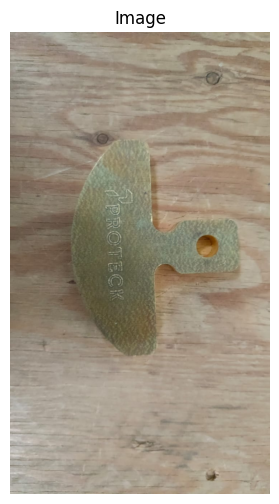

RuntimeError: Wrong input shape height=224, width=3. Expected image height and width divisible by 32. Consider pad your images to shape (224, 32).

In [19]:
# read and print image
img_path = img_paths[1]
img = cv2.imread(img_path)
print_image(img)

# model
model = smp.Unet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3)
# model.to(device)
model.eval()

# Preprocess the image
'''
image = cv2.resize(img, (512, 512))
image = cv2.resize(img, (224, 224))
image = image.astype(np.float32) / 255.
image = np.transpose(image, (2, 0, 1))
image = torch.tensor(image).unsqueeze(0)
'''
image = cv2.resize(img, (224, 224))
preprocess_input = get_preprocessing_fn('resnet34', pretrained='imagenet')
img_transformed = preprocess_input(image)
# img_transformed.to(device)

# Use the UNet++ model to perform semantic segmentation
with torch.no_grad():
    outputs = model(img_transformed)
    prediction = torch.sigmoid(outputs[0])

# Postprocess the predictions to get the boundary of the sheet metal part
prediction = prediction.detach().cpu().numpy().squeeze()
prediction = np.round(prediction).astype(np.uint8)
contours, hierarchy = cv2.findContours(prediction, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
boundary = cv2.drawContours(img, contours, -1, (0, 0, 255), 3)

print_image(boundary)

In [36]:
from torchvision.transforms import ToTensor

img_path = img_paths[1]
img = cv2.imread(img_path)
print(img.shape)
img = cv2.resize(img, (224,224))
preprocess_input = get_preprocessing_fn('resnet34', pretrained='imagenet')
img = preprocess_input(img)

to_tensor = ToTensor()
img_tensor = to_tensor(img).unsqueeze(0)
print(img_tensor.shape)

model = smp.Unet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3)
mask = model.predict(img_tensor)

plt.imshow(mask[0][0], cmap='gray')
plt.show()

(1280, 720, 3)
torch.Size([1, 3, 224, 224])


RuntimeError: expected scalar type Double but found Float

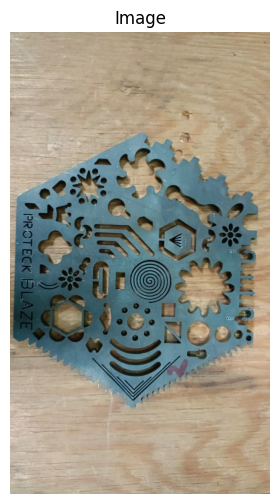

(1280, 720, 3)
torch.Size([1, 3, 256, 256])


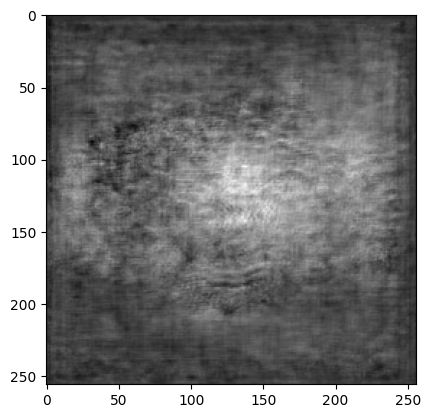

In [50]:
from torchvision.transforms import ToTensor

img_path = img_paths[10]
img = cv2.imread(img_path)
print_image(img)
print(img.shape)
img = cv2.resize(img, (256,256))
preprocess_input = get_preprocessing_fn('resnet34', pretrained='imagenet')
img = preprocess_input(img)

to_tensor = ToTensor()
img_tensor = to_tensor(img).unsqueeze(0).float()
print(img_tensor.shape)

model = smp.Unet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3)
mask = model.predict(img_tensor)

plt.imshow(mask[0][0], cmap='gray')
plt.show()

In [ ]:
%%time